In [1]:
import json
import os
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation, BatchNormalization

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [52]:
DATA_DIR = './data2/'

In [138]:
DATA_DIR2 = './data2/'
ids = os.listdir(DATA_DIR2)
pvm_angels = []
json_fps = [os.path.join(DATA_DIR2, image_id) for image_id in ids if image_id.startswith('catalog') and image_id.endswith('catalog')]
for file in json_fps:
    with open(file, 'r') as f:
        for line in f:            
            if (line.startswith('{')):
                jsonObj = json.loads(line)   
                imgFile = jsonObj['cam/image_array']
                image = cv2.imread(os.path.join(DATA_DIR2, 'images', imgFile))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
                image = image[65:200, :]
                #image = cv2.resize(image, (60,35))
                image = cv2.resize(image, None, fx=0.25, fy= 0.25)
                #image = cv2.resize(image, (60,60))
                jsonObj['image'] = image
                pvm_angels.append(jsonObj)


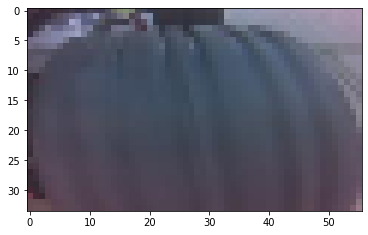

(34, 56, 3)

In [139]:
plt.imshow(pvm_angels[0]['image'])
plt.show()
pvm_angels[0]['image'].shape

In [140]:
#prepare and split data

df = pd.DataFrame(pvm_angels)

images = list(df['image'])
images = np.array(images) / 255.0
pwms = np.array(df['user/angle'])
pwms = (pwms+1)/2.0 #sigmoid activation

trainImagesX, testImagesX, trainPwmsX, testPwmsX = train_test_split(images, pwms, test_size=0.1, random_state=42)
trainImagesX, valImagesX, trainPwmsX, valPwmsX = train_test_split(trainImagesX, trainPwmsX, test_size=0.135, random_state=42)


In [141]:
import albumentations as A
transform = A.Compose([
    #A.IAAAdditiveGaussianNoise(p=0.2),
    A.GaussNoise(p=0.2),         
    A.OneOf(
        [
            A.CLAHE(p=1),
            A.RandomBrightness(p=1),
            A.RandomGamma(p=1),
        ],
        p=0.9,
    ),

    A.OneOf(
        [
            #A.IAASharpen(p=1),
            A.Sharpen(p=1),
            A.Blur(blur_limit=3, p=1),
            A.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.9,
    ),

    A.OneOf(
        [
            A.RandomContrast(p=1),
            A.HueSaturationValue(p=1),
        ],
        p=0.9,
    ),

    
])
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.5, brightness_by_max=False, p=1),    
])

    

/home/apandy/environemnts/car/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/apandy/environemnts/car/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [142]:
#implment augmentation 

augmentedTrainImages = []
for i in range(len(trainImagesX)):
    orig_image = trainImagesX[i]
    augmentedTrainImages.append(orig_image)
    for j in range(9):
        augmentedTrainImages.append(transform(image=orig_image)['image'])

augmentedTrainImages = np.array(augmentedTrainImages)        
augmentedPwms = np.array(trainPwmsX).repeat(10)

augmentedTrainImages.shape, augmentedPwms.shape

((23660, 34, 56, 3), (23660,))

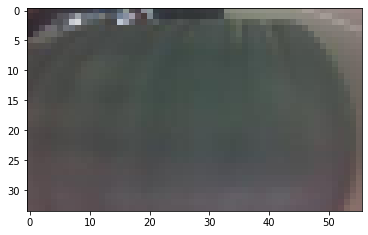

0.5


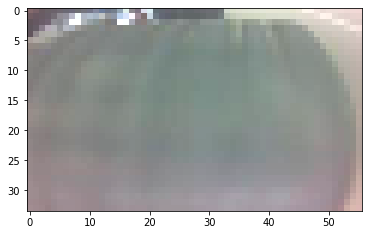

0.5


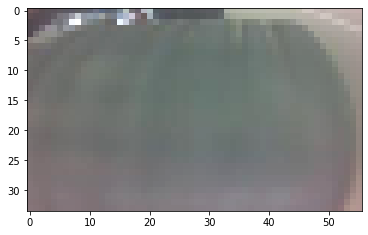

0.5


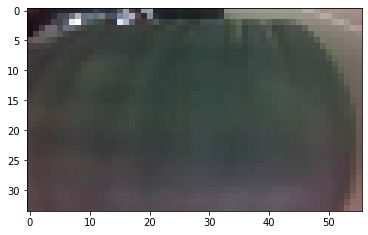

0.5


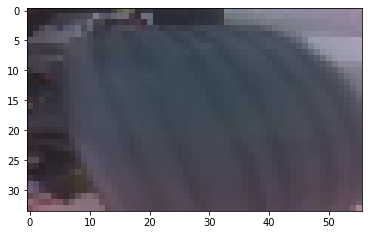

0.0


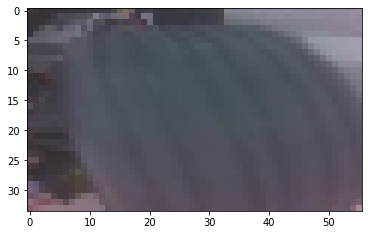

0.0


In [143]:
#for i in range(10):
plt.imshow(augmentedTrainImages[0])
plt.show()
print(augmentedPwms[0])
plt.imshow(augmentedTrainImages[1])
plt.show()
print(augmentedPwms[1])
plt.imshow(augmentedTrainImages[8])
plt.show()
print(augmentedPwms[8])
plt.imshow(augmentedTrainImages[9])
plt.show()
print(augmentedPwms[9])
plt.imshow(augmentedTrainImages[10])
plt.show()
print(augmentedPwms[10])
plt.imshow(augmentedTrainImages[11])
plt.show()
print(augmentedPwms[11])

In [144]:
input_shape = augmentedTrainImages[0].shape

model = Sequential()
model.add(Conv2D(56, kernel_size=(3,3),input_shape=input_shape ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(256, activation=tf.nn.relu))
model.add(Dropout(0.2))
#model.add(Dense(200,activation=tf.nn.softmax))
model.add(Dense(1,activation=tf.nn.sigmoid))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x=augmentedTrainImages,y=augmentedPwms,  validation_data=(valImagesX, valPwmsX), epochs=50)


Epoch 1/50
740/740 [==============================] - 2s 2ms/step - loss: 0.0611 - val_loss: 0.0569
Epoch 2/50
740/740 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0499
Epoch 3/50
740/740 [==============================] - 1s 2ms/step - loss: 0.0318 - val_loss: 0.0462
Epoch 4/50
740/740 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0456
Epoch 5/50
740/740 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0443
Epoch 6/50
740/740 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0481
Epoch 7/50
740/740 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0435
Epoch 8/50
740/740 [==============================] - 1s 2ms/step - loss: 0.0115 - val_loss: 0.0445
Epoch 9/50
740/740 [==============================] - 1s 2ms/step - loss: 0.0092 - val_loss: 0.0473
Epoch 10/50
740/740 [==============================] - 1s 2ms/step - loss: 0.0079 - val_loss: 0.0452

In [29]:
score = model.evaluate(testImagesX, testPwmsX, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0026078857481479645
Test accuracy: 0.42105263471603394


In [40]:
predict_x=model.predict(testImagesX) 
classex_x = np.argmax(predict_x,axis=1)

95/95 [==============================] - 0s 770us/step


In [11]:
model.save("x_model_s_dave_full") 

INFO:tensorflow:Assets written to: x_model_s_dave_full/assets


INFO:tensorflow:Assets written to: x_model_s_dave_full/assets


In [3]:
from tensorflow.keras.models import Sequential, save_model, load_model
model = load_model("x_model_s", compile = True)

import pickle
with open("x_model_s.pickle", "wb") as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://bd61f946-4944-4b59-b0f6-c41bf13e6df2/assets


INFO:tensorflow:Assets written to: ram://bd61f946-4944-4b59-b0f6-c41bf13e6df2/assets
